In [7]:
import torch
from torch_geometric.data import HeteroData
import torch.nn as nn
from torch_geometric.nn import NNConv, global_mean_pool 
import torch.optim as optim
from torch_geometric.nn import GlobalAttention
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.loader import DataLoader

In [8]:
import torch

# Load the hetero graph
data = torch.load("Graph_Results/HeteroGraphs_ScaledFinal/HeteroGraph_T1.pt", weights_only=False)

# Print node types and sizes
print("Node Types and Features:")
for ntype in data.node_types:
    print(f"  {ntype}: {data[ntype].x.shape}")

# Print edge types and count
print("\nEdge Types:")
for etype in data.edge_types:
    edge_index = data[etype].edge_index
    print(f"  {etype}: {edge_index.shape[1]} edges")

# Check a few values from cell node features
print("\nSample cell node features (first 5 rows):")
print(data["cell"].x[:5])


Node Types and Features:
  gene: torch.Size([269, 2])
  cell: torch.Size([1223, 7])
  pathway: torch.Size([808, 2])

Edge Types:
  ('gene', 'involved_in', 'pathway'): 7543 edges
  ('cell', 'expresses', 'gene'): 196479 edges

Sample cell node features (first 5 rows):
tensor([[ 0.6317,  1.1321,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.1880,  1.2070,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.5530,  0.0235,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.0073,  1.0278,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.3512,  1.3956,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000]])


In [9]:
import torch.nn as nn

class NodeFeatureEncoders(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()

        self.cell_encoder = nn.Sequential(
            nn.Linear(7, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),  # 🔁 Replaced BatchNorm1d
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.gene_encoder = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),  # 🔁 Replaced BatchNorm1d
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.pathway_encoder = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),  # 🔁 Replaced BatchNorm1d
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

    def forward(self, cell_x, gene_x, pathway_x):
        h_cell = self.cell_encoder(cell_x)
        h_gene = self.gene_encoder(gene_x)
        h_pathway = self.pathway_encoder(pathway_x)
        return h_cell, h_gene, h_pathway
        

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import NNConv, global_mean_pool

class SharedHierarchicalEncoder_NoAttention(nn.Module):
    def __init__(self, hidden_dim=64, lstm_hidden_dim=None, num_dosages=9, num_aux_outputs=1,
                 dropout=0.1, use_virtual_node=True):
        super().__init__()
        self.use_virtual_node = use_virtual_node
        self.hidden_dim = hidden_dim

        # === Node encoders
        self.node_encoders = NodeFeatureEncoders(hidden_dim)

        # === Edge MLPs for NNConv
        self.edge_mlp_cell_gene = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * hidden_dim)
        )
        self.edge_mlp_gene_pathway = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * hidden_dim)
        )

        # === Message Passing
        self.cell_to_gene_conv = NNConv(hidden_dim, hidden_dim, self.edge_mlp_cell_gene, aggr='mean')
        self.gene_to_pathway_conv = NNConv(hidden_dim, hidden_dim, self.edge_mlp_gene_pathway, aggr='mean')

        # === Global Mean Pooling (replaces attention)
        self.dropout = nn.Dropout(dropout)
        self.fuse_global = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        # === Optional auxiliary regression/classification head
        self.aux_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_aux_outputs)
        )

        # === Virtual Node (Dosage-aware)
        if self.use_virtual_node:
            lstm_dim = lstm_hidden_dim or hidden_dim
            self.dosage_embeddings = nn.Embedding(num_dosages, hidden_dim)
            self.virtual_norm = nn.LayerNorm(hidden_dim)
            self.dosage_lstm = nn.LSTM(hidden_dim, lstm_dim, batch_first=True)

            self.fuse_cell_virtual = nn.Sequential(
                nn.Linear(hidden_dim + lstm_dim, hidden_dim),
                nn.ReLU(),
                nn.LayerNorm(hidden_dim)
            )
            self.fuse_gene_virtual = nn.Sequential(
                nn.Linear(hidden_dim + lstm_dim, hidden_dim),
                nn.ReLU(),
                nn.LayerNorm(hidden_dim)
            )
            self.fuse_pathway_virtual = nn.Sequential(
                nn.Linear(hidden_dim + lstm_dim, hidden_dim),
                nn.ReLU(),
                nn.LayerNorm(hidden_dim)
            )

    def refine_virtuals_with_lstm(self):
        raw_dosage_embeddings = self.dosage_embeddings.weight.unsqueeze(0)
        lstm_out, _ = self.dosage_lstm(raw_dosage_embeddings)
        return self.virtual_norm(lstm_out.squeeze(0))

    def forward(self, data, dosage_idx=None):
        cell_x = data["cell"].x
        gene_x = data["gene"].x
        pathway_x = data["pathway"].x

        h_cell, h_gene, h_pathway = self.node_encoders(cell_x, gene_x, pathway_x)

        if self.use_virtual_node:
            refined_dosage_virtuals = self.refine_virtuals_with_lstm()
            dosage_virtual = refined_dosage_virtuals[dosage_idx]

            cell_batch = data["cell"].batch
            gene_batch = data["gene"].batch
            pathway_batch = data["pathway"].batch

            h_cell = self.fuse_cell_virtual(torch.cat([h_cell, dosage_virtual[cell_batch]], dim=1))
            h_gene = self.fuse_gene_virtual(torch.cat([h_gene, dosage_virtual[gene_batch]], dim=1))
            h_pathway = self.fuse_pathway_virtual(torch.cat([h_pathway, dosage_virtual[pathway_batch]], dim=1))
        else:
            dosage_virtual = torch.zeros(h_cell.size(0), self.hidden_dim, device=h_cell.device)

        # === Message Passing
        h_gene_updated = self.cell_to_gene_conv(
            (h_cell, h_gene),
            data["cell", "expresses", "gene"].edge_index,
            data["cell", "expresses", "gene"].edge_attr
        )
        h_pathway_updated = self.gene_to_pathway_conv(
            (h_gene_updated, h_pathway),
            data["gene", "involved_in", "pathway"].edge_index,
            data["gene", "involved_in", "pathway"].edge_attr
        )

        # === Global Mean Pooling (instead of attention)
        pooled_pathway = global_mean_pool(h_pathway_updated, data['pathway'].batch)

        graph_embedding = self.fuse_global(torch.cat([
            pooled_pathway,
            dosage_virtual
        ], dim=1))

        aux_output = self.aux_head(graph_embedding)

        # === Normalize
        h_cell = F.normalize(h_cell, p=2, dim=-1)
        h_gene_updated = F.normalize(h_gene_updated, p=2, dim=-1)
        h_pathway_updated = F.normalize(h_pathway_updated, p=2, dim=-1)

        return {
            "h_cell": h_cell,
            "h_gene": h_gene_updated,
            "h_pathway": h_pathway_updated,
            "dosage_virtual": dosage_virtual,
            "graph_embedding": graph_embedding,
            "aux_output": aux_output.squeeze(),
            "pathway_attention_weights": None  # <-- explicitly None now
        }


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HierarchicalDecoder_NoAttention(nn.Module):
    def __init__(self, hidden_dim=64, dropout=0.1, use_virtual_node=True):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.use_virtual_node = use_virtual_node

        # === Pathway → Gene decoding
        self.decode_to_pathways_fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout)
        )
        self.decode_to_pathways_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        # === Gene reconstruction MLP
        self.gene_reconstruction_fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        # === Optional dosage conditioning
        if self.use_virtual_node:
            self.dosage_embedding = nn.Linear(hidden_dim, hidden_dim)

        # === Optional auxiliary head
        self.aux_pathway_score_head = nn.Linear(hidden_dim, 1)

    def forward(self, h_pathway_updated, h_gene_updated, graph_embedding, dosage_virtual=None):
        B, N_pathways, H = h_pathway_updated.size()
        _, N_genes, _ = h_gene_updated.size()

        if self.use_virtual_node and dosage_virtual is not None:
            graph_embedding = graph_embedding + self.dosage_embedding(dosage_virtual)

        # === Pathway reconstruction
        graph_expanded = graph_embedding.unsqueeze(1).expand(-1, N_pathways, -1)
        pathway_input = torch.cat([h_pathway_updated, graph_expanded], dim=-1)
        pathway_hidden = self.decode_to_pathways_fc(pathway_input)
        pathway_recon = self.decode_to_pathways_proj(pathway_hidden)  # [B, N_pathways, H]

        # === Gene reconstruction (simple projection)
        gene_recon = self.gene_reconstruction_fc(h_gene_updated)      # [B, N_genes, H]
        gene_recon = F.normalize(gene_recon, p=2, dim=-1)

        # === Pathway auxiliary scores
        aux_pathway_scores = self.aux_pathway_score_head(pathway_recon).squeeze(-1)

        return {
            "reconstructed_pathways": pathway_recon,
            "reconstructed_genes": gene_recon,
            "aux_pathway_scores": aux_pathway_scores,
            "reconstructed_cells": None,
            "aux_cell_scores": None,
            "attention_pathway_to_gene": None,
            "attention_gene_to_cell": None
        }


In [23]:
import os
import torch

def load_all_dosage_graphs_for_batching(graph_dir, pattern_prefix="HeteroGraph_T"):
    graphs = []
    dosage_keys = []

    for fname in os.listdir(graph_dir):
        if fname.startswith(pattern_prefix) and fname.endswith(".pt"):
            dosage_key = fname.replace(".pt", "").replace(pattern_prefix, "T")
            path = os.path.join(graph_dir, fname)
            data = torch.load(path, weights_only=False)
            data.dosage_key = dosage_key  # for reference
            dosage_keys.append(dosage_key)
            graphs.append(data)

    # Sort graphs and dosage keys by numeric dosage (T1, T2.5, ..., T320)
    sorted_pairs = sorted(zip(dosage_keys, graphs), key=lambda x: float(x[0].replace("T", "")))
    sorted_dosage_keys, sorted_graphs = zip(*sorted_pairs)

    # Create dosage index mapping
    dosage_levels = [float(k.replace("T", "")) for k in sorted_dosage_keys]
    dosage_to_idx = {
        f"T{int(d) if d.is_integer() else d}": i for i, d in enumerate(dosage_levels)
    }

    # Add dosage_idx to each graph
    for graph, key in zip(sorted_graphs, sorted_dosage_keys):
        graph.dosage_idx = torch.tensor([dosage_to_idx[key]], dtype=torch.long)

    return list(sorted_graphs), dosage_to_idx


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HierarchicalLoss_NoAttention(nn.Module):
    def __init__(
        self,
        lambda_pathway=1.0,
        lambda_gene=1.0,
        use_stat_alignment=True,
        reduction='mean'
    ):
        super().__init__()
        self.lambda_pathway = lambda_pathway
        self.lambda_gene = lambda_gene
        self.use_stat_alignment = use_stat_alignment
        self.reduction = reduction

    def forward(self, outputs, targets):
        loss_components = {}

        # === Pathway reconstruction loss
        L_pathway = F.mse_loss(
            outputs["reconstructed_pathways"],
            targets["h_pathway"],
            reduction=self.reduction
        )
        loss_components["pathway_loss"] = L_pathway

        # === Gene reconstruction loss
        recon = outputs["reconstructed_genes"]
        target = targets["h_gene"]
        L_gene = F.mse_loss(recon, target, reduction=self.reduction)

        if self.use_stat_alignment:
            std_diff = F.mse_loss(recon.std(dim=1), target.std(dim=1), reduction=self.reduction)
            mean_diff = F.mse_loss(recon.mean(dim=1), target.mean(dim=1), reduction=self.reduction)
            L_gene += 0.2 * (std_diff + mean_diff)

        loss_components["gene_loss"] = L_gene

        # === Total loss (no attention term)
        total = self.lambda_pathway * L_pathway + self.lambda_gene * L_gene
        loss_components["total_loss"] = total

        return total, loss_components


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HierarchicalLoss_NoAttention(nn.Module):
    def __init__(
        self,
        lambda_pathway=1.0,
        lambda_gene=1.0,
        use_stat_alignment=True,
        reduction='mean'
    ):
        super().__init__()
        self.lambda_pathway = lambda_pathway
        self.lambda_gene = lambda_gene
        self.use_stat_alignment = use_stat_alignment
        self.reduction = reduction

    def forward(self, outputs, targets):
        loss_components = {}

        # === Pathway reconstruction loss
        L_pathway = F.mse_loss(
            outputs["reconstructed_pathways"],
            targets["h_pathway"],
            reduction=self.reduction
        )
        loss_components["pathway_loss"] = L_pathway

        # === Gene reconstruction loss
        recon = outputs["reconstructed_genes"]
        target = targets["h_gene"]
        L_gene = F.mse_loss(recon, target, reduction=self.reduction)

        if self.use_stat_alignment:
            std_diff = F.mse_loss(recon.std(dim=1), target.std(dim=1), reduction=self.reduction)
            mean_diff = F.mse_loss(recon.mean(dim=1), target.mean(dim=1), reduction=self.reduction)
            L_gene += 0.2 * (std_diff + mean_diff)

        loss_components["gene_loss"] = L_gene

        # === Total loss (no attention term)
        total = self.lambda_pathway * L_pathway + self.lambda_gene * L_gene
        loss_components["total_loss"] = total

        return total, loss_components


In [40]:
def train_encoder_decoder_model_no_attention(
    encoder, decoder, graphs_list, dosage_to_idx,
    optimizer=None,
    device='cuda',
    epochs=100,
    loss_weights=None,
    save_path=None,
    lr=1e-3,
    weight_decay=1e-5,
    patience=30,
    min_delta=1e-3,
    batch_size=2
):
    import os
    import json
    from torch_geometric.loader import DataLoader
    from torch_geometric.utils import to_dense_batch
    from torch.optim import Adam
    from torch.optim.lr_scheduler import ReduceLROnPlateau

    encoder = encoder.to(device)
    decoder = decoder.to(device)

    loss_kwargs = {k: v for k, v in (loss_weights or {}).items() if k != "monitored_losses"}
    criterion = HierarchicalLoss_NoAttention(**loss_kwargs).to(device)

    monitored_keys = loss_weights.get("monitored_losses", ["total_loss"]) if loss_weights else ["total_loss"]
    best_monitored_loss = {k: float("inf") for k in monitored_keys} if len(monitored_keys) > 1 else float("inf")

    if optimizer is None:
        optimizer = Adam(
            list(encoder.parameters()) + list(decoder.parameters()),
            lr=lr,
            weight_decay=weight_decay
        )

    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5, verbose=True, min_lr=1e-5)
    loader = DataLoader(graphs_list, batch_size=batch_size, shuffle=False)

    loss_log = []
    best_recon_outputs_log = []  # ✅ Store only the best epoch's outputs
    best_epoch = 0
    epochs_no_improve = 0

    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        epoch_loss_dict = {k: 0.0 for k in ["pathway_loss", "gene_loss", "total_loss"]}
        epoch_recon_outputs = []  # ✅ Temp buffer for this epoch

        for batch in loader:
            batch = batch.to(device)
            encoder_out = encoder(batch, batch.dosage_idx)

            h_pathway, _ = to_dense_batch(encoder_out["h_pathway"], batch["pathway"].batch)
            h_gene, _ = to_dense_batch(encoder_out["h_gene"], batch["gene"].batch)

            decoder_out = decoder(
                h_pathway_updated=h_pathway,
                h_gene_updated=h_gene,
                graph_embedding=encoder_out["graph_embedding"],
                dosage_virtual=encoder_out.get("dosage_virtual")
            )

            targets = {
                "h_pathway": h_pathway.detach(),
                "h_gene": h_gene.detach()
            }

            loss, loss_components = criterion(decoder_out, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            for key in epoch_loss_dict:
                epoch_loss_dict[key] += loss_components[key].item()

            # ✅ Save current batch reconstruction to temp buffer
            epoch_recon_outputs.append({
                "dosage_idx": int(batch.dosage_idx.item()),
                "real_h_gene": h_gene.detach().cpu().tolist(),
                "real_h_pathway": h_pathway.detach().cpu().tolist(),
                "reconstructed_genes": decoder_out["reconstructed_genes"].detach().cpu().tolist(),
                "reconstructed_pathways": decoder_out["reconstructed_pathways"].detach().cpu().tolist()
            })

        # === Epoch summary ===
        num_batches = len(loader)
        avg_loss_dict = {k: v / num_batches for k, v in epoch_loss_dict.items()}
        loss_log.append(avg_loss_dict)
        scheduler_loss = avg_loss_dict["total_loss"]
        scheduler.step(scheduler_loss)

        improvement = False
        for k in monitored_keys:
            current = avg_loss_dict[k]
            if isinstance(best_monitored_loss, dict):
                if current < best_monitored_loss[k] - min_delta:
                    best_monitored_loss[k] = current
                    improvement = True
            else:
                if current < best_monitored_loss - min_delta:
                    best_monitored_loss = current
                    improvement = True

        graph_norm = encoder_out["graph_embedding"].norm().item()
        print("Epoch {:03d} | Total: {:.4f} | P: {:.4f}, G: {:.4f} | Graph Norm: {:.4f}".format(
            epoch+1, avg_loss_dict['total_loss'], avg_loss_dict['pathway_loss'],
            avg_loss_dict['gene_loss'], graph_norm))

        if improvement:
            best_epoch = epoch + 1
            best_recon_outputs_log = epoch_recon_outputs  # ✅ Keep best
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping at epoch {} after {} stagnant epochs.".format(epoch+1, patience))
            break

    # === Save model and logs ===
    if save_path:
        torch.save({
            "encoder": encoder.state_dict(),
            "decoder": decoder.state_dict()
        }, save_path)
        print("Model saved to {}".format(save_path))

        loss_log_path = save_path.replace(".pth", "_loss_log.json")
        with open(loss_log_path, "w") as f:
            json.dump(loss_log, f, indent=2)
        print("Loss log saved to {}".format(loss_log_path))

        recon_output_path = save_path.replace(".pth", "_recon_outputs.json")
        with open(recon_output_path, "w") as f:
            json.dump(best_recon_outputs_log, f, indent=2)  # ✅ Only best epoch
        print("Best reconstructions saved to {}".format(recon_output_path))

    return encoder, decoder, loss_log, best_epoch


In [41]:
import torch

# === Step 1: Load graphs
graph_dir = "Graph_Results/HeteroGraphs_ScaledFinal"
graphs_list, dosage_to_idx = load_all_dosage_graphs_for_batching(graph_dir)

# === Step 2: Instantiate no-attention models
hidden_dim = 64
encoder = SharedHierarchicalEncoder_NoAttention(hidden_dim=hidden_dim, num_dosages=len(dosage_to_idx))
decoder = HierarchicalDecoder_NoAttention(hidden_dim=hidden_dim)

# === Step 3: Define loss weights
loss_weights = {
    "lambda_pathway": 2.0,
    "lambda_gene": 1.0,
    "use_stat_alignment": True,
    "monitored_losses": ["total_loss"]
}

# === Step 4: Train
trained_encoder, trained_decoder, loss_log, best_epoch = train_encoder_decoder_model_no_attention(
    encoder=encoder,
    decoder=decoder,
    graphs_list=graphs_list,
    dosage_to_idx=dosage_to_idx,
    device='cpu',
    epochs=60,
    save_path="trained_model_NoAttention.pth",
    loss_weights=loss_weights,
    batch_size=1
)

print(f"\n🎯 Best Epoch: {best_epoch}")


Epoch 001 | Total: 2.0165 | P: 0.9862, G: 0.0440 | Graph Norm: 7.9915
Epoch 002 | Total: 1.8822 | P: 0.9220, G: 0.0382 | Graph Norm: 8.0400
Epoch 003 | Total: 1.7101 | P: 0.8396, G: 0.0308 | Graph Norm: 8.0560
Epoch 004 | Total: 1.6014 | P: 0.7892, G: 0.0229 | Graph Norm: 8.0567
Epoch 005 | Total: 1.5202 | P: 0.7512, G: 0.0178 | Graph Norm: 8.0622
Epoch 006 | Total: 1.4602 | P: 0.7223, G: 0.0155 | Graph Norm: 8.0668
Epoch 007 | Total: 1.4094 | P: 0.6975, G: 0.0144 | Graph Norm: 8.0711
Epoch 008 | Total: 1.3545 | P: 0.6707, G: 0.0131 | Graph Norm: 8.0745
Epoch 009 | Total: 1.3041 | P: 0.6458, G: 0.0124 | Graph Norm: 8.0772
Epoch 010 | Total: 1.2516 | P: 0.6200, G: 0.0116 | Graph Norm: 8.0798
Epoch 011 | Total: 1.2014 | P: 0.5952, G: 0.0110 | Graph Norm: 8.0823
Epoch 012 | Total: 1.1526 | P: 0.5711, G: 0.0105 | Graph Norm: 8.0840
Epoch 013 | Total: 1.1046 | P: 0.5472, G: 0.0101 | Graph Norm: 8.0853
Epoch 014 | Total: 1.0584 | P: 0.5243, G: 0.0098 | Graph Norm: 8.0864
Epoch 015 | Total: 1

In [42]:
import torch

# === Load dosage map
graph_dir = "Graph_Results/HeteroGraphs_ScaledFinal"
graphs_list, dosage_to_idx = load_all_dosage_graphs_for_batching(graph_dir)

# === Instantiate model architectures (same as training)
hidden_dim = 64
encoder = SharedHierarchicalEncoder_NoAttention(hidden_dim=hidden_dim, num_dosages=len(dosage_to_idx))
decoder = HierarchicalDecoder_NoAttention(hidden_dim=hidden_dim)

# === Load trained weights
checkpoint = torch.load("trained_model_NoAttention.pth", map_location='cpu')
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])

# === Set models to eval mode
encoder.eval()
decoder.eval()


HierarchicalDecoder_NoAttention(
  (decode_to_pathways_fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (decode_to_pathways_proj): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (gene_reconstruction_fc): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (dosage_embedding): Linear(in_features=64, out_features=64, bias=True)
  (aux_pathway_score_head): Linear(in_features=64, out_features=1, bias=True)
)

In [43]:
import json
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# === Load JSON output ===
with open("trained_model_NoAttention_recon_outputs.json", "r") as f:
    recon_data = json.load(f)


In [44]:
with open("trained_model_NoAttention_recon_outputs.json", "r") as f:
    data = json.load(f)

print(f"Total entries in JSON: {len(data)}")


Total entries in JSON: 9


/home/sachit/.local/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


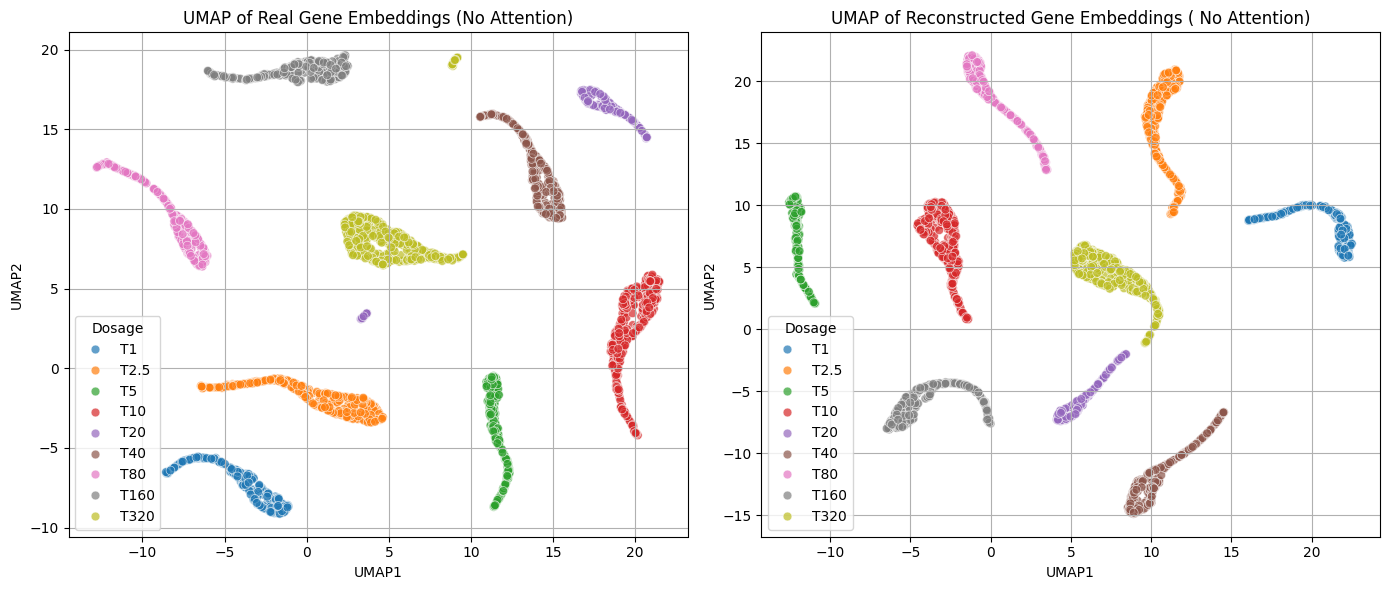

In [46]:
import json
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# === Load saved recon output ===
with open("trained_model_NoAttention_recon_outputs.json", "r") as f:
    recon_data = json.load(f)

# === Mapping index to dosage label ===
idx_to_dosage = {
    0: "T1", 1: "T2.5", 2: "T5", 3: "T10", 4: "T20",
    5: "T40", 6: "T80", 7: "T160", 8: "T320"
}

# === Prepare containers ===
real_feats = []
recon_feats = []
labels = []

for entry in recon_data:
    dosage_name = idx_to_dosage[entry["dosage_idx"]]
    
    recon_gene = np.array(entry["reconstructed_genes"]).squeeze(0)  # [N_genes, H]
    real_gene = np.array(entry["real_h_gene"]).squeeze(0)           # Corrected here ✅

    recon_feats.append(recon_gene)
    real_feats.append(real_gene)
    labels += [dosage_name] * recon_gene.shape[0]

# === Stack features
recon_all = np.vstack(recon_feats)
real_all = np.vstack(real_feats)

# === Run UMAP
umap_model = umap.UMAP(n_neighbors=30, min_dist=0.3, metric="euclidean", random_state=42)
real_umap = umap_model.fit_transform(real_all)
recon_umap = umap_model.fit_transform(recon_all)

# === Create DataFrames
real_df = pd.DataFrame(real_umap, columns=["UMAP1", "UMAP2"])
real_df["Dosage"] = labels
real_df["Type"] = "Real"

recon_df = pd.DataFrame(recon_umap, columns=["UMAP1", "UMAP2"])
recon_df["Dosage"] = labels
recon_df["Type"] = "Reconstructed"

# === Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(data=real_df, x="UMAP1", y="UMAP2", hue="Dosage", ax=axes[0],
                s=40, alpha=0.7, palette="tab10")
axes[0].set_title("UMAP of Real Gene Embeddings (No Attention)")
axes[0].grid(True)

sns.scatterplot(data=recon_df, x="UMAP1", y="UMAP2", hue="Dosage", ax=axes[1],
                s=40, alpha=0.7, palette="tab10")
axes[1].set_title("UMAP of Reconstructed Gene Embeddings ( No Attention)")
axes[1].grid(True)

plt.tight_layout()
plt.savefig("UMAP_GENE_NoAttention.png", dpi=600, bbox_inches="tight")
plt.show()


In [47]:
import json
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

# === Load saved recon output ===
with open("trained_model_NoAttention_recon_outputs.json", "r") as f:
    recon_data = json.load(f)

# === Mapping index to dosage label ===
idx_to_dosage = {
    0: "T1", 1: "T2.5", 2: "T5", 3: "T10", 4: "T20",
    5: "T40", 6: "T80", 7: "T160", 8: "T320"
}

# === Compute metrics for each dosage
results = []
for entry in recon_data:
    dosage = idx_to_dosage[entry["dosage_idx"]]
    
    real = np.array(entry["real_h_gene"]).squeeze(0)            # shape [N, H]
    recon = np.array(entry["reconstructed_genes"]).squeeze(0)   # shape [N, H]
    
    mse = mean_squared_error(real, recon)
    cos_sim = cosine_similarity(real, recon).diagonal().mean()  # average across all gene embeddings

    results.append({
        "Dosage": dosage,
        "MSE": mse,
        "CosineSimilarity": cos_sim
    })

# === Convert to DataFrame and print
df = pd.DataFrame(results)
print(df)


  Dosage       MSE  CosineSimilarity
0     T1  0.003099          0.900821
1   T2.5  0.002956          0.905415
2     T5  0.002551          0.918376
3    T10  0.002932          0.906166
4    T20  0.002511          0.919654
5    T40  0.002598          0.916859
6    T80  0.003059          0.902113
7   T160  0.002795          0.910554
8   T320  0.002408          0.922954


/home/sachit/.local/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


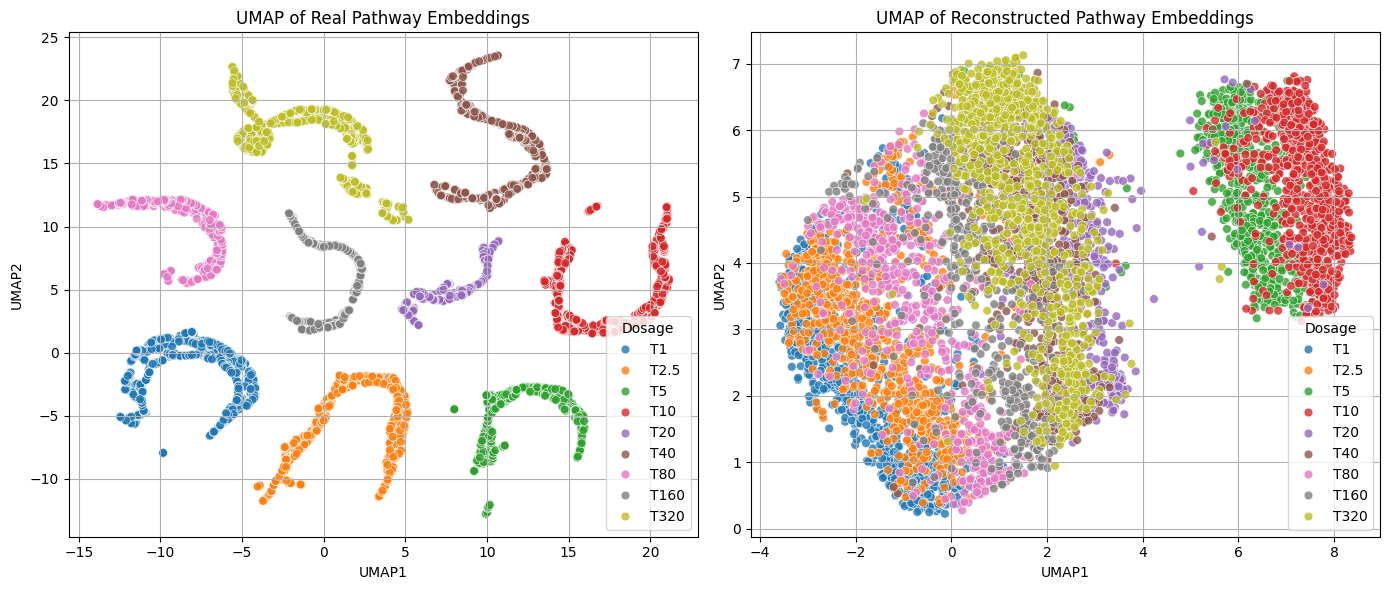

In [75]:
import json
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# === Load saved recon output ===
with open("trained_model_NoAttention_recon_outputs.json", "r") as f:
    recon_data = json.load(f)

# === Mapping index to dosage label ===
idx_to_dosage = {
    0: "T1", 1: "T2.5", 2: "T5", 3: "T10", 4: "T20",
    5: "T40", 6: "T80", 7: "T160", 8: "T320"
}

# === Prepare containers ===
real_feats = []
recon_feats = []
labels = []

for entry in recon_data:
    dosage_name = idx_to_dosage[entry["dosage_idx"]]
    
    # shape: [N_pathways, H]
    real_pathway = np.array(entry["real_h_pathway"]).squeeze(0)
    recon_pathway = np.array(entry["reconstructed_pathways"]).squeeze(0)

    real_feats.append(real_pathway)
    recon_feats.append(recon_pathway)
    labels += [dosage_name] * real_pathway.shape[0]

# === Stack features
real_all = np.vstack(real_feats)
recon_all = np.vstack(recon_feats)

# === Run UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.2, metric="cosine", random_state=42)
real_umap = umap_model.fit_transform(real_all)
recon_umap = umap_model.fit_transform(recon_all)

# === Create DataFrames
real_df = pd.DataFrame(real_umap, columns=["UMAP1", "UMAP2"])
real_df["Dosage"] = labels
real_df["Type"] = "Real"

recon_df = pd.DataFrame(recon_umap, columns=["UMAP1", "UMAP2"])
recon_df["Dosage"] = labels
recon_df["Type"] = "Reconstructed"

# === Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(data=real_df, x="UMAP1", y="UMAP2", hue="Dosage", ax=axes[0],
                s=40, alpha=0.8, palette="tab10")
axes[0].set_title("UMAP of Real Pathway Embeddings")
axes[0].grid(True)

sns.scatterplot(data=recon_df, x="UMAP1", y="UMAP2", hue="Dosage", ax=axes[1],
                s=40, alpha=0.8, palette="tab10")
axes[1].set_title("UMAP of Reconstructed Pathway Embeddings")
axes[1].grid(True)

plt.tight_layout()
plt.savefig("UMAP_PATHWAY_NoAttention.png", dpi=600, bbox_inches="tight")
plt.show()


In [51]:
import json
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

# === Load reconstruction outputs
with open("trained_model_NoAttention_recon_outputs.json", "r") as f:
    recon_data = json.load(f)

# === Dosage index mapping
idx_to_dosage = {
    0: "T1", 1: "T2.5", 2: "T5", 3: "T10", 4: "T20",
    5: "T40", 6: "T80", 7: "T160", 8: "T320"
}

# === Store results
metrics = []

for entry in recon_data:
    dosage_label = idx_to_dosage[entry["dosage_idx"]]
    real = np.array(entry["real_h_pathway"]).squeeze(0)
    recon = np.array(entry["reconstructed_pathways"]).squeeze(0)

    mse = mean_squared_error(real.flatten(), recon.flatten())
    cosine_sim = np.mean(np.diag(cosine_similarity(real, recon)))

    metrics.append([dosage_label, mse, cosine_sim])

# === Create DataFrame
df = pd.DataFrame(metrics, columns=["Dosage", "MSE", "CosineSimilarity"])

# === Sort by dosage numerically
df["Dosage_num"] = df["Dosage"].str.replace("T", "").astype(float)
df = df.sort_values("Dosage_num").drop(columns=["Dosage_num"])

# === Format and print
df["MSE"] = df["MSE"].round(6)
df["CosineSimilarity"] = df["CosineSimilarity"].round(6)

print(df.to_string(index=False))


Dosage      MSE  CosineSimilarity
    T1 0.030944          0.643565
  T2.5 0.030198          0.650411
    T5 0.031302          0.614537
   T10 0.033522          0.585190
   T20 0.029714          0.642326
   T40 0.029071          0.655137
   T80 0.029071          0.651199
  T160 0.029136          0.638916
  T320 0.029394          0.640275


## NO LSTM

In [52]:
import torch.nn as nn

class NodeFeatureEncoders(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()

        self.cell_encoder = nn.Sequential(
            nn.Linear(7, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),  # 🔁 Replaced BatchNorm1d
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.gene_encoder = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),  # 🔁 Replaced BatchNorm1d
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.pathway_encoder = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),  # 🔁 Replaced BatchNorm1d
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

    def forward(self, cell_x, gene_x, pathway_x):
        h_cell = self.cell_encoder(cell_x)
        h_gene = self.gene_encoder(gene_x)
        h_pathway = self.pathway_encoder(pathway_x)
        return h_cell, h_gene, h_pathway
        
from torch_geometric.nn import GlobalAttention

class GlobalAttentionWithWeights(GlobalAttention):
    def forward(self, x, index, ptr=None, dim_size=None, dim=0):
        """
        x: Node embeddings
        index: Index tensor (typically the batch vector)
        """
        gate = self.gate_nn(x).squeeze(-1)      # [N]
        gate = torch.sigmoid(gate)              # attention weights
        x_weighted = x * gate.unsqueeze(-1)     # [N, F]

        # Perform aggregation (mean by default)
        out = torch.zeros(dim_size or int(index.max()) + 1, x.size(-1), device=x.device)
        out = out.index_add(dim, index, x_weighted)

        return out, gate

In [53]:
class SharedHierarchicalEncoder_NoLSTM(nn.Module):
    def __init__(self, hidden_dim=64, num_dosages=9, num_aux_outputs=1,
                 dropout=0.1, use_virtual_node=True):
        super().__init__()
        self.use_virtual_node = use_virtual_node
        self.hidden_dim = hidden_dim             

        self.node_encoders = NodeFeatureEncoders(hidden_dim)

        self.edge_mlp_cell_gene = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * hidden_dim)
        )
        self.edge_mlp_gene_pathway = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * hidden_dim)
        )

        self.cell_to_gene_conv = NNConv(hidden_dim, hidden_dim, self.edge_mlp_cell_gene, aggr='mean')
        self.gene_to_pathway_conv = NNConv(hidden_dim, hidden_dim, self.edge_mlp_gene_pathway, aggr='mean')

        self.att_pool = GlobalAttentionWithWeights(gate_nn=nn.Linear(hidden_dim, 1))

        self.dropout = nn.Dropout(dropout)
        self.fuse_global = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        self.aux_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_aux_outputs)
        )

        if self.use_virtual_node:
            self.dosage_embeddings = nn.Embedding(num_dosages, hidden_dim)
            self.virtual_norm = nn.LayerNorm(hidden_dim)
            self.fuse_cell_virtual = nn.Sequential(
                nn.Linear(hidden_dim * 2, hidden_dim),
                nn.ReLU(),
                nn.LayerNorm(hidden_dim)
            )
            self.fuse_gene_virtual = nn.Sequential(
                nn.Linear(hidden_dim * 2, hidden_dim),
                nn.ReLU(),
                nn.LayerNorm(hidden_dim)
            )
            self.fuse_pathway_virtual = nn.Sequential(
                nn.Linear(hidden_dim * 2, hidden_dim),
                nn.ReLU(),
                nn.LayerNorm(hidden_dim)
            )

    def forward(self, data, dosage_idx=None):
        cell_x = data["cell"].x
        gene_x = data["gene"].x
        pathway_x = data["pathway"].x

        h_cell, h_gene, h_pathway = self.node_encoders(cell_x, gene_x, pathway_x)

        if self.use_virtual_node:
            dosage_virtual = self.virtual_norm(self.dosage_embeddings(dosage_idx))  # [B, H]
            cell_batch = data["cell"].batch
            gene_batch = data["gene"].batch
            pathway_batch = data["pathway"].batch

            h_cell = self.fuse_cell_virtual(torch.cat([
                h_cell, dosage_virtual[cell_batch]
            ], dim=1))
            h_gene = self.fuse_gene_virtual(torch.cat([
                h_gene, dosage_virtual[gene_batch]
            ], dim=1))
            h_pathway = self.fuse_pathway_virtual(torch.cat([
                h_pathway, dosage_virtual[pathway_batch]
            ], dim=1))
        else:
            dosage_virtual = torch.zeros(h_cell.size(0), self.hidden_dim, device=h_cell.device)

        h_gene_updated = self.cell_to_gene_conv(
            (h_cell, h_gene),
            data["cell", "expresses", "gene"].edge_index,
            data["cell", "expresses", "gene"].edge_attr
        )
        h_pathway_updated = self.gene_to_pathway_conv(
            (h_gene_updated, h_pathway),
            data["gene", "involved_in", "pathway"].edge_index,
            data["gene", "involved_in", "pathway"].edge_attr
        )

        pooled_pathway, pathway_attention_weights = self.att_pool(
            h_pathway_updated, data["pathway"].batch
        )

        graph_embedding = self.fuse_global(torch.cat([
            pooled_pathway, dosage_virtual
        ], dim=1))
        aux_output = self.aux_head(graph_embedding)

        h_cell = F.normalize(h_cell, p=2, dim=-1)
        h_gene_updated = F.normalize(h_gene_updated, p=2, dim=-1)
        h_pathway_updated = F.normalize(h_pathway_updated, p=2, dim=-1)

        return {
            "h_cell": h_cell,
            "h_gene": h_gene_updated,
            "h_pathway": h_pathway_updated,
            "dosage_virtual": dosage_virtual,
            "graph_embedding": graph_embedding,
            "aux_output": aux_output.squeeze(),
            "pathway_attention_weights": pathway_attention_weights
        }


In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HierarchicalDecoder_NoLSTM(nn.Module):
    def __init__(self, hidden_dim=64, num_heads=2, dropout=0.1, use_virtual_node=True):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.use_virtual_node = use_virtual_node

        # === Pathway seed projection (unused unless you add seed later)
        self.pathway_seed_proj = nn.Linear(hidden_dim, hidden_dim)

        # === Gene projection head before query
        self.gene_proj_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        # === Query projection for attention
        self.gene_query_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        # === Pathway reconstruction MLP
        self.decode_to_pathways_fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout)
        )
        self.decode_to_pathways_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        # === Multi-head attention from pathway → gene (store attn weights)
        self.pathway_to_gene_attn = nn.MultiheadAttention(
            hidden_dim, num_heads, dropout=dropout, batch_first=True
        )

        # === Optional dosage embedding
        if self.use_virtual_node:
            self.dosage_embedding = nn.Linear(hidden_dim, hidden_dim)

        # === Auxiliary scoring head for interpretability
        self.aux_pathway_score_head = nn.Linear(hidden_dim, 1)

    def forward(self, h_pathway_updated, h_gene_updated, graph_embedding, dosage_virtual=None):
        B, N_pathways, H = h_pathway_updated.size()
        _, N_genes, _ = h_gene_updated.size()

        # === Add virtual dosage node (if applicable)
        if self.use_virtual_node and dosage_virtual is not None:
            graph_embedding = graph_embedding + self.dosage_embedding(dosage_virtual)

        # === Pathway reconstruction
        graph_expanded = graph_embedding.unsqueeze(1).expand(-1, N_pathways, -1)
        pathway_input = torch.cat([h_pathway_updated, graph_expanded], dim=-1)
        pathway_hidden = self.decode_to_pathways_fc(pathway_input)
        pathway_recon = self.decode_to_pathways_proj(pathway_hidden)  # [B, N_pathways, H]

        # === Gene projection and attention-based reconstruction
        h_gene_projected = self.gene_proj_head(h_gene_updated)
        gene_query = self.gene_query_proj(h_gene_projected)

        gene_recon, attn_p2g = self.pathway_to_gene_attn(
            query=gene_query,
            key=pathway_recon,
            value=pathway_recon,
            key_padding_mask=None,
            need_weights=True
        )

        # Residual + dropout
        gene_recon = F.dropout(gene_recon, p=0.1, training=self.training) + gene_query

        # === New: L2 Normalize reconstructed gene embeddings
        gene_recon = F.normalize(gene_recon, p=2, dim=-1)

        # === Optional auxiliary output
        aux_pathway_scores = self.aux_pathway_score_head(pathway_recon).squeeze(-1)

        return {
            "reconstructed_pathways": pathway_recon,
            "reconstructed_genes": gene_recon,
            "aux_pathway_scores": aux_pathway_scores,
            "attention_pathway_to_gene": attn_p2g  # shape [B, num_heads, N_genes, N_pathways]
        }


In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import json
from torch.optim import Adam
from torch_geometric.loader import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch_geometric.utils import to_dense_batch
from torch.optim.lr_scheduler import ReduceLROnPlateau

class HierarchicalLoss(nn.Module):
    def __init__(
        self,
        lambda_pathway=1.0,
        lambda_gene=1.0,
        lambda_attention=0.2,
        use_stat_alignment=True,
        reduction='mean'
    ):
        super().__init__()
        self.lambda_pathway = lambda_pathway
        self.lambda_gene = lambda_gene
        self.lambda_attention = lambda_attention
        self.use_stat_alignment = use_stat_alignment
        self.reduction = reduction

    def forward(self, outputs, targets):
        loss_components = {}

        # Pathway reconstruction loss
        L_pathway = F.mse_loss(
            outputs["reconstructed_pathways"],
            targets["h_pathway"],
            reduction=self.reduction
        )
        loss_components["pathway_loss"] = L_pathway

        # Gene reconstruction loss
        recon = outputs["reconstructed_genes"]
        target = targets["h_gene"]
        L_gene = F.mse_loss(recon, target, reduction=self.reduction)

        if self.use_stat_alignment:
            std_diff = F.mse_loss(recon.std(dim=1), target.std(dim=1), reduction=self.reduction)
            mean_diff = F.mse_loss(recon.mean(dim=1), target.mean(dim=1), reduction=self.reduction)
            L_gene += 0.2 * (std_diff + mean_diff)

        loss_components["gene_loss"] = L_gene

        # Attention regularization
        attn = outputs.get("attention_pathway_to_gene", None)
        if attn is not None:
            if attn.dim() == 4:
                entropy = -(attn * torch.log(attn + 1e-8)).sum(dim=-1).mean()
            elif attn.dim() == 3:
                entropy = -(attn * torch.log(attn + 1e-8)).sum(dim=-1).mean()
            else:
                entropy = torch.tensor(0.0, device=attn.device)
        else:
            entropy = torch.tensor(0.0, device=recon.device)

        loss_components["attention_reg_loss"] = entropy

        total = (
            self.lambda_pathway * L_pathway +
            self.lambda_gene * L_gene +
            self.lambda_attention * entropy
        )
        loss_components["total_loss"] = total

        return total, loss_components

In [67]:
import os
import json
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_batch
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_encoder_decoder_model(
    encoder, decoder, graphs_list, dosage_to_idx,
    optimizer=None,
    device='cuda',
    epochs=100,
    loss_weights=None,
    save_path=None,
    lr=1e-3,
    weight_decay=1e-5,
    patience=30,
    min_delta=1e-3,
    batch_size=2
):
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    loss_kwargs = {k: v for k, v in (loss_weights or {}).items() if k not in ["log_grad_norm", "monitored_losses"]}
    criterion = HierarchicalLoss(**loss_kwargs).to(device)

    monitored_keys = loss_weights.get("monitored_losses", ["total_loss"]) if loss_weights else ["total_loss"]
    best_monitored_loss = {k: float("inf") for k in monitored_keys} if len(monitored_keys) > 1 else float("inf")

    if optimizer is None:
        optimizer = Adam(
            list(encoder.parameters()) + list(decoder.parameters()),
            lr=lr,
            weight_decay=weight_decay
        )

    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5, verbose=True, min_lr=1e-5)
    loader = DataLoader(graphs_list, batch_size=batch_size, shuffle=False)

    best_recon_outputs = None
    best_attention_entropy = None
    best_epoch = 0
    epochs_no_improve = 0

    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        epoch_loss_dict = {k: 0.0 for k in ["pathway_loss", "gene_loss", "attention_reg_loss", "total_loss"]}
        epoch_attn_entropy = []
        epoch_recon_outputs = []

        for batch in loader:
            batch = batch.to(device)
            encoder_out = encoder(batch, batch.dosage_idx)
            h_pathway, _ = to_dense_batch(encoder_out["h_pathway"], batch["pathway"].batch)
            h_gene, _ = to_dense_batch(encoder_out["h_gene"], batch["gene"].batch)

            decoder_out = decoder(
                h_pathway_updated=h_pathway,
                h_gene_updated=h_gene,
                graph_embedding=encoder_out["graph_embedding"],
                dosage_virtual=encoder_out.get("dosage_virtual")
            )

            targets = {
                "h_pathway": h_pathway.detach(),
                "h_gene": h_gene.detach()
            }

            loss, loss_components = criterion(decoder_out, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            for key in epoch_loss_dict:
                epoch_loss_dict[key] += loss_components[key].item()

            # Save reconstruction for best epoch only
            epoch_recon_outputs.append({
                "dosage_idx": int(batch.dosage_idx.item()),
                "attention": decoder_out.get("attention_pathway_to_gene", None).detach().cpu().tolist()
                    if decoder_out.get("attention_pathway_to_gene") is not None else None,
                "reconstructed_pathways": decoder_out["reconstructed_pathways"].detach().cpu().tolist(),
                "reconstructed_genes": decoder_out["reconstructed_genes"].detach().cpu().tolist(),
                "real_h_gene": h_gene.detach().cpu().tolist(),         # ✅ Added for UMAP/cosine similarity
                "real_h_pathway": h_pathway.detach().cpu().tolist()    # ✅ Added for future pathway analysis
            })

            # Track attention entropy
            attn = decoder_out.get("attention_pathway_to_gene", None)
            if attn is not None:
                entropy = (-attn * torch.log(attn + 1e-6)).sum(dim=-1)
                entropy = entropy.mean(dim=-1).mean(dim=0)
                epoch_attn_entropy.append(entropy.detach().cpu())

        num_batches = len(loader)
        avg_loss_dict = {k: v / num_batches for k, v in epoch_loss_dict.items()}

        scheduler_loss = avg_loss_dict["total_loss"]
        scheduler.step(scheduler_loss)

        improvement = False
        for k in monitored_keys:
            current = avg_loss_dict[k]
            if isinstance(best_monitored_loss, dict):
                if current < best_monitored_loss[k] - min_delta:
                    best_monitored_loss[k] = current
                    improvement = True
            else:
                if current < best_monitored_loss - min_delta:
                    best_monitored_loss = current
                    improvement = True

        graph_norm = encoder_out["graph_embedding"].norm().item()
        print("Epoch {:03d} | Total: {:.4f} | P: {:.4f}, G: {:.4f}, A: {:.4f} | Graph Norm: {:.4f}".format(
            epoch+1, avg_loss_dict['total_loss'], avg_loss_dict['pathway_loss'],
            avg_loss_dict['gene_loss'], avg_loss_dict['attention_reg_loss'], graph_norm))

        if improvement:
            best_epoch = epoch + 1
            epochs_no_improve = 0
            best_recon_outputs = epoch_recon_outputs
            best_attention_entropy = torch.stack(epoch_attn_entropy).mean(dim=0).tolist() if epoch_attn_entropy else None
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping at epoch {} after {} stagnant epochs.".format(epoch+1, patience))
            break

    # Save final model
    if save_path:
        torch.save({
            "encoder": encoder.state_dict(),
            "decoder": decoder.state_dict()
        }, save_path)
        print("✅ Model saved to:", save_path)

        if best_recon_outputs:
            recon_output_path = save_path.replace(".pth", "_recon_outputs.json")
            with open(recon_output_path, "w") as f:
                json.dump(best_recon_outputs, f, indent=2)
            print("🧠 Best epoch reconstruction saved to:", recon_output_path)

        if best_attention_entropy:
            attn_log_path = save_path.replace(".pth", "_attn_entropy.json")
            with open(attn_log_path, "w") as f:
                json.dump(best_attention_entropy, f, indent=2)
            print("📊 Best attention entropy saved to:", attn_log_path)

    return encoder, decoder, best_epoch


In [68]:
import torch

# === Step 1: Load graphs
graph_dir = "Graph_Results/HeteroGraphs_ScaledFinal"
graphs_list, dosage_to_idx = load_all_dosage_graphs_for_batching(graph_dir)

# === Step 2: Instantiate encoder and decoder (LSTM removed, attention retained)
hidden_dim = 64
encoder = SharedHierarchicalEncoder_NoLSTM(hidden_dim=hidden_dim, num_dosages=len(dosage_to_idx))
decoder = HierarchicalDecoder_NoLSTM(hidden_dim=hidden_dim)  # ✅ LSTM-free decoder

# === Step 3: Define loss weights
loss_weights = {
    "lambda_pathway": 2.0,
    "lambda_gene": 1.0,
    "lambda_attention": 0.2,           # ✅ Attention regularization
    "use_stat_alignment": True,
    "log_grad_norm": True,
    "monitored_losses": ["total_loss"]
}

# === Step 4: Train and retain only best epoch's reconstructions
trained_encoder, trained_decoder, best_epoch = train_encoder_decoder_model(
    encoder=encoder,
    decoder=decoder,
    graphs_list=graphs_list,
    dosage_to_idx=dosage_to_idx,
    device='cpu',                                
    epochs=30,
    save_path="trained_model_nolstm.pth",        # ✅ Save path reflects model variant
    loss_weights=loss_weights,
    batch_size=1
)

print(f"\n🎯 Best Epoch (LSTM-free): {best_epoch}")


Epoch 001 | Total: 3.3307 | P: 1.0008, G: 0.0363, A: 6.4635 | Graph Norm: 7.9941
Epoch 002 | Total: 3.2068 | P: 0.9418, G: 0.0323, A: 6.4549 | Graph Norm: 8.0050
Epoch 003 | Total: 3.0997 | P: 0.8930, G: 0.0264, A: 6.4366 | Graph Norm: 8.0156
Epoch 004 | Total: 2.9785 | P: 0.8508, G: 0.0205, A: 6.2816 | Graph Norm: 8.0232
Epoch 005 | Total: 2.6995 | P: 0.8328, G: 0.0203, A: 5.0680 | Graph Norm: 8.0286
Epoch 006 | Total: 2.2498 | P: 0.8470, G: 0.0237, A: 2.6604 | Graph Norm: 8.1024
Epoch 007 | Total: 2.0191 | P: 0.8501, G: 0.0223, A: 1.4827 | Graph Norm: 8.1387
Epoch 008 | Total: 1.7801 | P: 0.8102, G: 0.0167, A: 0.7154 | Graph Norm: 8.1473
Epoch 009 | Total: 1.7002 | P: 0.7734, G: 0.0129, A: 0.7020 | Graph Norm: 8.1583
Epoch 010 | Total: 1.5799 | P: 0.7394, G: 0.0086, A: 0.4620 | Graph Norm: 8.1740
Epoch 011 | Total: 1.5326 | P: 0.7105, G: 0.0069, A: 0.5234 | Graph Norm: 8.1865
Epoch 012 | Total: 1.4210 | P: 0.6904, G: 0.0073, A: 0.1649 | Graph Norm: 8.1971
Epoch 013 | Total: 1.4294 | 

In [69]:
import torch

# === Step 1: Load graphs and dosage map
graph_dir = "Graph_Results/HeteroGraphs_ScaledFinal"
graphs_list, dosage_to_idx = load_all_dosage_graphs_for_batching(graph_dir)

# === Step 2: Instantiate model architectures (LSTM-free, attention-enabled)
hidden_dim = 64
encoder = SharedHierarchicalEncoder_NoLSTM(hidden_dim=hidden_dim, num_dosages=len(dosage_to_idx))
decoder = HierarchicalDecoder_NoLSTM(hidden_dim=hidden_dim)

# === Step 3: Load trained weights
checkpoint_path = "trained_model_nolstm.pth"  # ✅ Make sure path matches your training save
checkpoint = torch.load(checkpoint_path, map_location='cpu')  # or 'cuda' if using GPU

encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])

# === Step 4: Set to evaluation mode
encoder.eval()
decoder.eval()

# === Step 5 (optional): Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder.to(device)
decoder.to(device)

print("✅ Model successfully loaded and ready for inference.")


✅ Model successfully loaded and ready for inference.


In [70]:
import json
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# === Load JSON output from LSTM-free attention-enabled model ===
with open("trained_model_nolstm_recon_outputs.json", "r") as f:
    recon_data = json.load(f)

print(f"Total entries in JSON: {len(recon_data)}")


Total entries in JSON: 9


/home/sachit/.local/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


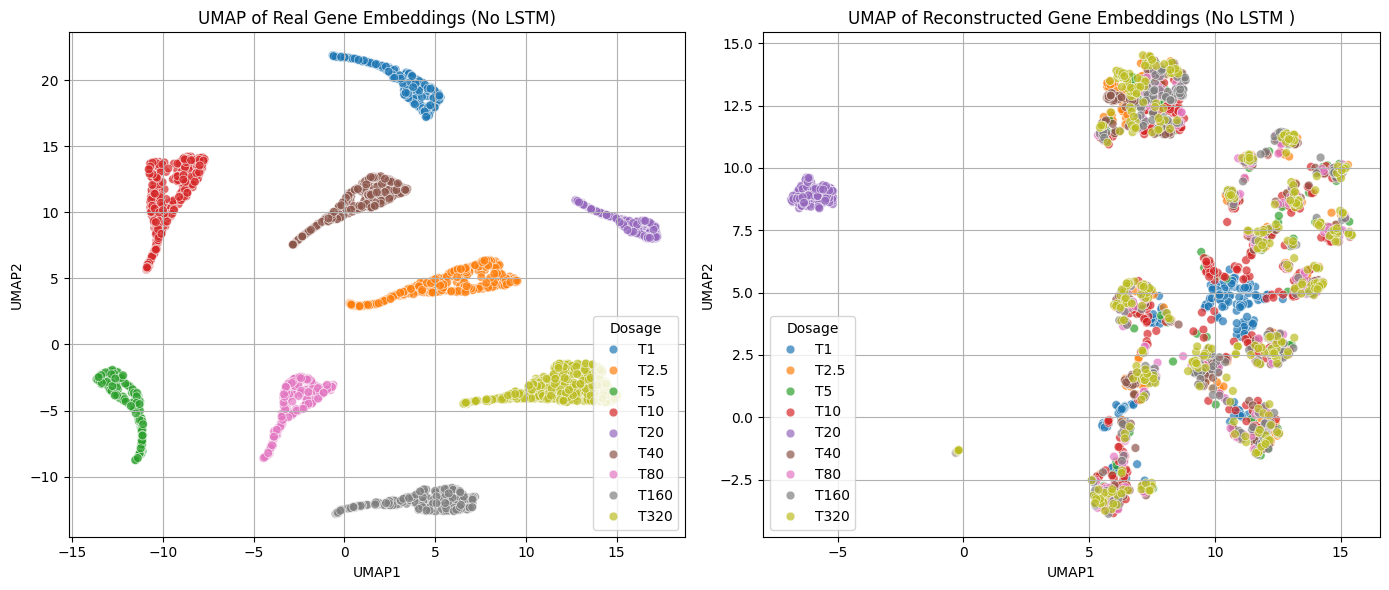

In [73]:
import json
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# === Load saved recon output from LSTM-free attention model ===
with open("trained_model_nolstm_recon_outputs.json", "r") as f:
    recon_data = json.load(f)

# === Mapping index to dosage label ===
idx_to_dosage = {
    0: "T1", 1: "T2.5", 2: "T5", 3: "T10", 4: "T20",
    5: "T40", 6: "T80", 7: "T160", 8: "T320"
}

# === Prepare containers
real_feats = []
recon_feats = []
labels = []

for entry in recon_data:
    dosage_name = idx_to_dosage[entry["dosage_idx"]]

    recon_gene = np.array(entry["reconstructed_genes"]).squeeze(0)   # [N_genes, H]
    real_gene = np.array(entry["real_h_gene"]).squeeze(0)           # [N_genes, H]

    recon_feats.append(recon_gene)
    real_feats.append(real_gene)
    labels += [dosage_name] * recon_gene.shape[0]

# === Stack features
recon_all = np.vstack(recon_feats)
real_all = np.vstack(real_feats)

# === Run UMAP
umap_model = umap.UMAP(n_neighbors=30, min_dist=0.3, metric="euclidean", random_state=42)
real_umap = umap_model.fit_transform(real_all)
recon_umap = umap_model.fit_transform(recon_all)

# === Create DataFrames
real_df = pd.DataFrame(real_umap, columns=["UMAP1", "UMAP2"])
real_df["Dosage"] = labels
real_df["Type"] = "Real"

recon_df = pd.DataFrame(recon_umap, columns=["UMAP1", "UMAP2"])
recon_df["Dosage"] = labels
recon_df["Type"] = "Reconstructed"

# === Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(data=real_df, x="UMAP1", y="UMAP2", hue="Dosage", ax=axes[0],
                s=40, alpha=0.7, palette="tab10")
axes[0].set_title("UMAP of Real Gene Embeddings (No LSTM)")
axes[0].grid(True)

sns.scatterplot(data=recon_df, x="UMAP1", y="UMAP2", hue="Dosage", ax=axes[1],
                s=40, alpha=0.7, palette="tab10")
axes[1].set_title("UMAP of Reconstructed Gene Embeddings (No LSTM )")
axes[1].grid(True)

plt.tight_layout()
plt.savefig("UMAP_GENE_nolstm_attention.png", dpi=600, bbox_inches="tight")
plt.show()


In [72]:
import json
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

# === Load reconstructions ===
with open("trained_model_nolstm_recon_outputs.json", "r") as f:
    recon_data = json.load(f)

# === Index to dosage mapping ===
idx_to_dosage = {
    0: "T1", 1: "T2.5", 2: "T5", 3: "T10", 4: "T20",
    5: "T40", 6: "T80", 7: "T160", 8: "T320"
}

# === Collect metrics
metrics = []

for entry in recon_data:
    dosage = idx_to_dosage[entry["dosage_idx"]]

    real_gene = np.array(entry["real_h_gene"]).squeeze(0)
    recon_gene = np.array(entry["reconstructed_genes"]).squeeze(0)

    cos_sim = np.mean([
        cosine_similarity(real_gene[i].reshape(1, -1), recon_gene[i].reshape(1, -1))[0, 0]
        for i in range(real_gene.shape[0])
    ])
    mse = mean_squared_error(real_gene, recon_gene)

    metrics.append({
        "Dosage": dosage,
        "CosineSimilarity": cos_sim,
        "MSE": mse
    })

# === Aggregate by dosage
df = pd.DataFrame(metrics)
df_summary = df.groupby("Dosage").mean().reset_index()

# === Optional: sort dosages in order
dosage_order = ["T1", "T2.5", "T5", "T10", "T20", "T40", "T80", "T160", "T320"]
df_summary["Dosage"] = pd.Categorical(df_summary["Dosage"], categories=dosage_order, ordered=True)
df_summary = df_summary.sort_values("Dosage")

# === Print the result
print("\n📊 Per-Dosage Gene Reconstruction Metrics:")
print(df_summary.to_string(index=False, float_format="%.6f"))



📊 Per-Dosage Gene Reconstruction Metrics:
Dosage  CosineSimilarity      MSE
    T1          0.882925 0.003659
  T2.5          0.884908 0.003597
    T5          0.883018 0.003656
   T10          0.897424 0.003206
   T20          0.811422 0.005893
   T40          0.899416 0.003143
   T80          0.885973 0.003563
  T160          0.875040 0.003905
  T320          0.899712 0.003134


/home/sachit/.local/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


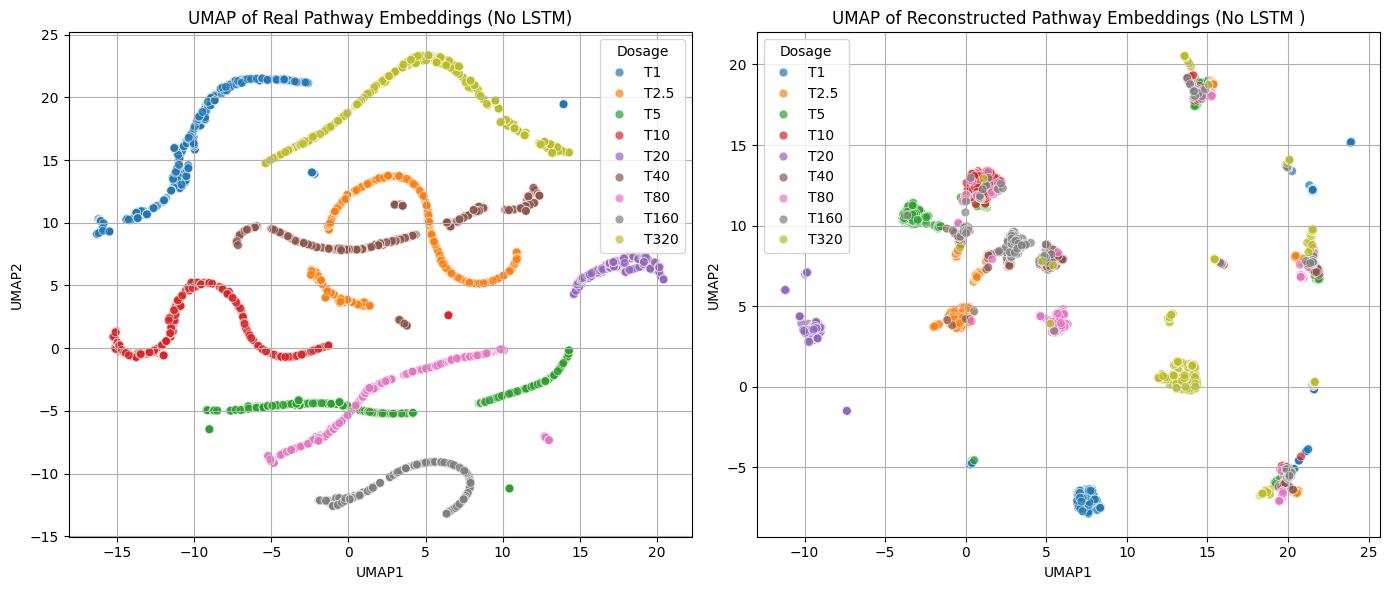

In [76]:
import json
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# === Load JSON outputs ===
with open("trained_model_nolstm_recon_outputs.json", "r") as f:
    recon_data = json.load(f)

# === Dosage map
idx_to_dosage = {
    0: "T1", 1: "T2.5", 2: "T5", 3: "T10", 4: "T20",
    5: "T40", 6: "T80", 7: "T160", 8: "T320"
}

# === Containers
real_feats = []
recon_feats = []
labels = []

# === Extract pathway embeddings across all entries
for entry in recon_data:
    dosage = idx_to_dosage[entry["dosage_idx"]]

    real_pw = np.array(entry["real_h_pathway"]).squeeze(0)             # [N_pathways, H]
    recon_pw = np.array(entry["reconstructed_pathways"]).squeeze(0)   # [N_pathways, H]

    real_feats.append(real_pw)
    recon_feats.append(recon_pw)
    labels += [dosage] * real_pw.shape[0]

# === Stack
real_all = np.vstack(real_feats)
recon_all = np.vstack(recon_feats)

# === UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
real_umap = umap_model.fit_transform(real_all)
recon_umap = umap_model.fit_transform(recon_all)

# === Create DataFrames
real_df = pd.DataFrame(real_umap, columns=["UMAP1", "UMAP2"])
real_df["Dosage"] = labels
real_df["Type"] = "Real"

recon_df = pd.DataFrame(recon_umap, columns=["UMAP1", "UMAP2"])
recon_df["Dosage"] = labels
recon_df["Type"] = "Reconstructed"

# === Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(data=real_df, x="UMAP1", y="UMAP2", hue="Dosage", ax=axes[0],
                s=40, alpha=0.7, palette="tab10")
axes[0].set_title("UMAP of Real Pathway Embeddings (No LSTM)")
axes[0].grid(True)

sns.scatterplot(data=recon_df, x="UMAP1", y="UMAP2", hue="Dosage", ax=axes[1],
                s=40, alpha=0.7, palette="tab10")
axes[1].set_title("UMAP of Reconstructed Pathway Embeddings (No LSTM )")
axes[1].grid(True)

plt.tight_layout()
plt.savefig("UMAP_PATHWAY_nolstm_attention.png", dpi=600, bbox_inches="tight")
plt.show()


In [77]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# === Convert labels to numpy array
labels = np.array(labels)

# === Unique dosages
dosages = sorted(set(labels), key=lambda x: float(x[1:]) if 'T' in x else x)

# === Containers
mse_per_dosage = []
cosine_per_dosage = []

# === Per-dosage evaluation
for d in dosages:
    idxs = labels == d
    real_d = real_all[idxs]
    recon_d = recon_all[idxs]

    mse = mean_squared_error(real_d, recon_d)
    cos_sim = np.mean(np.diag(cosine_similarity(real_d, recon_d)))

    mse_per_dosage.append(mse)
    cosine_per_dosage.append(cos_sim)

# === Overall evaluation
overall_mse = mean_squared_error(real_all, recon_all)
overall_cosine = np.mean(np.diag(cosine_similarity(real_all, recon_all)))

# === Create DataFrame
df_eval = pd.DataFrame({
    "Dosage": dosages,
    "MSE": mse_per_dosage,
    "CosineSimilarity": cosine_per_dosage
})

# Append overall
df_eval.loc[len(df_eval)] = ["Overall", overall_mse, overall_cosine]

# === Display
print(df_eval.round(6))


    Dosage       MSE  CosineSimilarity
0       T1  0.334208          0.641750
1     T2.5  0.333354          0.587510
2       T5  0.335031          0.573203
3      T10  0.328507          0.614922
4      T20  0.528706          0.352417
5      T40  0.321134          0.599846
6      T80  0.333174          0.564221
7     T160  0.323333          0.577101
8     T320  0.327003          0.617308
9  Overall  0.341845          0.585217


## No Virtual Node

In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import NNConv
from torch_geometric.utils import to_dense_batch

class SharedHierarchicalEncoder_NoVirtual(nn.Module):
    def __init__(self, hidden_dim=64, num_aux_outputs=1, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim             

        # === Node encoders (external class expected)
        self.node_encoders = NodeFeatureEncoders(hidden_dim)

        # === Edge MLPs for NNConv
        self.edge_mlp_cell_gene = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * hidden_dim)
        )
        self.edge_mlp_gene_pathway = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * hidden_dim)
        )

        # === Message Passing
        self.cell_to_gene_conv = NNConv(hidden_dim, hidden_dim, self.edge_mlp_cell_gene, aggr='mean')
        self.gene_to_pathway_conv = NNConv(hidden_dim, hidden_dim, self.edge_mlp_gene_pathway, aggr='mean')

        # === Attention Pooling
        self.att_pool = GlobalAttentionWithWeights(gate_nn=nn.Linear(hidden_dim, 1))

        self.dropout = nn.Dropout(dropout)

        # === Final graph fusion (no virtual node)
        self.fuse_global = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        # === Optional auxiliary regression/classification head
        self.aux_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_aux_outputs)
        )

    def forward(self, data, dosage_idx=None):
        cell_x = data["cell"].x
        gene_x = data["gene"].x
        pathway_x = data["pathway"].x

        h_cell, h_gene, h_pathway = self.node_encoders(cell_x, gene_x, pathway_x)

        # === Graph Convolution
        h_gene_updated = self.cell_to_gene_conv(
            (h_cell, h_gene),
            data["cell", "expresses", "gene"].edge_index,
            data["cell", "expresses", "gene"].edge_attr
        )
        h_pathway_updated = self.gene_to_pathway_conv(
            (h_gene_updated, h_pathway),
            data["gene", "involved_in", "pathway"].edge_index,
            data["gene", "involved_in", "pathway"].edge_attr
        )

        # === Attention Pooling (per-graph)
        pooled_pathway, pathway_attention_weights = self.att_pool(
            h_pathway_updated,
            data['pathway'].batch
        )

        # === Fallback dosage virtual vector (zeros)
        batch_size = pooled_pathway.size(0)
        device = pooled_pathway.device
        dosage_virtual = torch.zeros(batch_size, self.hidden_dim, device=device)

        # === Final graph-level vector
        graph_embedding = self.fuse_global(torch.cat([
            pooled_pathway,
            dosage_virtual
        ], dim=1))

        aux_output = self.aux_head(graph_embedding)

        # === Normalize embeddings
        h_cell = F.normalize(h_cell, p=2, dim=-1)
        h_gene_updated = F.normalize(h_gene_updated, p=2, dim=-1)
        h_pathway_updated = F.normalize(h_pathway_updated, p=2, dim=-1)

        return {
            "h_cell": h_cell,
            "h_gene": h_gene_updated,
            "h_pathway": h_pathway_updated,
            "dosage_virtual": dosage_virtual,
            "graph_embedding": graph_embedding,
            "aux_output": aux_output.squeeze(),
            "pathway_attention_weights": pathway_attention_weights
        }


In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HierarchicalDecoder_NoVirtual(nn.Module):
    def __init__(self, hidden_dim=64, num_heads=2, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim

        # === Pathway seed projection (optional for seeding)
        self.pathway_seed_proj = nn.Linear(hidden_dim, hidden_dim)

        # === Gene projection head before query
        self.gene_proj_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        # === Query projection for attention
        self.gene_query_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        # === Pathway reconstruction MLP
        self.decode_to_pathways_fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout)
        )
        self.decode_to_pathways_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        # === Multi-head attention from pathway → gene
        self.pathway_to_gene_attn = nn.MultiheadAttention(
            hidden_dim, num_heads, dropout=dropout, batch_first=True
        )

        # === Auxiliary pathway score head
        self.aux_pathway_score_head = nn.Linear(hidden_dim, 1)

    def forward(self, h_pathway_updated, h_gene_updated, graph_embedding, dosage_virtual=None):
        B, N_pathways, H = h_pathway_updated.size()
        _, N_genes, _ = h_gene_updated.size()

        # === Use raw graph embedding (no dosage addition)
        graph_expanded = graph_embedding.unsqueeze(1).expand(-1, N_pathways, -1)
        pathway_input = torch.cat([h_pathway_updated, graph_expanded], dim=-1)
        pathway_hidden = self.decode_to_pathways_fc(pathway_input)
        pathway_recon = self.decode_to_pathways_proj(pathway_hidden)  # [B, N_pathways, H]

        # === Gene reconstruction via attention
        h_gene_projected = self.gene_proj_head(h_gene_updated)
        gene_query = self.gene_query_proj(h_gene_projected)

        gene_recon, attn_p2g = self.pathway_to_gene_attn(
            query=gene_query,
            key=pathway_recon,
            value=pathway_recon,
            key_padding_mask=None,
            need_weights=True
        )

        gene_recon = F.dropout(gene_recon, p=0.1, training=self.training) + gene_query
        gene_recon = F.normalize(gene_recon, p=2, dim=-1)

        aux_pathway_scores = self.aux_pathway_score_head(pathway_recon).squeeze(-1)

        return {
            "reconstructed_pathways": pathway_recon,
            "reconstructed_genes": gene_recon,
            "aux_pathway_scores": aux_pathway_scores,
            "attention_pathway_to_gene": attn_p2g
        }


In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import json
from torch.optim import Adam
from torch_geometric.loader import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch_geometric.utils import to_dense_batch
from torch.optim.lr_scheduler import ReduceLROnPlateau

class HierarchicalLoss(nn.Module):
    def __init__(
        self,
        lambda_pathway=1.0,
        lambda_gene=1.0,
        lambda_attention=0.2,
        use_stat_alignment=True,
        reduction='mean'
    ):
        super().__init__()
        self.lambda_pathway = lambda_pathway
        self.lambda_gene = lambda_gene
        self.lambda_attention = lambda_attention
        self.use_stat_alignment = use_stat_alignment
        self.reduction = reduction

    def forward(self, outputs, targets):
        loss_components = {}

        # Pathway reconstruction loss
        L_pathway = F.mse_loss(
            outputs["reconstructed_pathways"],
            targets["h_pathway"],
            reduction=self.reduction
        )
        loss_components["pathway_loss"] = L_pathway

        # Gene reconstruction loss
        recon = outputs["reconstructed_genes"]
        target = targets["h_gene"]
        L_gene = F.mse_loss(recon, target, reduction=self.reduction)

        if self.use_stat_alignment:
            std_diff = F.mse_loss(recon.std(dim=1), target.std(dim=1), reduction=self.reduction)
            mean_diff = F.mse_loss(recon.mean(dim=1), target.mean(dim=1), reduction=self.reduction)
            L_gene += 0.2 * (std_diff + mean_diff)

        loss_components["gene_loss"] = L_gene

        # Attention regularization
        attn = outputs.get("attention_pathway_to_gene", None)
        if attn is not None:
            if attn.dim() == 4:
                entropy = -(attn * torch.log(attn + 1e-8)).sum(dim=-1).mean()
            elif attn.dim() == 3:
                entropy = -(attn * torch.log(attn + 1e-8)).sum(dim=-1).mean()
            else:
                entropy = torch.tensor(0.0, device=attn.device)
        else:
            entropy = torch.tensor(0.0, device=recon.device)

        loss_components["attention_reg_loss"] = entropy

        total = (
            self.lambda_pathway * L_pathway +
            self.lambda_gene * L_gene +
            self.lambda_attention * entropy
        )
        loss_components["total_loss"] = total

        return total, loss_components

In [88]:
def train_encoder_decoder_model(
    encoder, decoder, graphs_list, dosage_to_idx,
    optimizer=None,
    device='cuda',
    epochs=100,
    loss_weights=None,
    save_path=None,
    lr=1e-3,
    weight_decay=1e-5,
    patience=30,
    min_delta=1e-3,
    batch_size=2
):
    import os
    import json
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    loss_kwargs = {k: v for k, v in (loss_weights or {}).items() if k not in ["log_grad_norm", "monitored_losses"]}
    criterion = HierarchicalLoss(**loss_kwargs).to(device)

    monitored_keys = loss_weights.get("monitored_losses", ["total_loss"]) if loss_weights else ["total_loss"]
    best_monitored_loss = {k: float("inf") for k in monitored_keys} if len(monitored_keys) > 1 else float("inf")

    if optimizer is None:
        optimizer = Adam(
            list(encoder.parameters()) + list(decoder.parameters()),
            lr=lr,
            weight_decay=weight_decay
        )

    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5, verbose=True, min_lr=1e-5)
    loader = DataLoader(graphs_list, batch_size=batch_size, shuffle=False)

    loss_log = []
    attention_log = []
    best_recon_outputs_log = []  # ✅ Best epoch only
    best_epoch = 0
    best_model = None
    epochs_no_improve = 0

    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        epoch_loss_dict = {k: 0.0 for k in ["pathway_loss", "gene_loss", "attention_reg_loss", "total_loss"]}
        epoch_attn_entropy = []
        current_recon_outputs_log = []  # ✅ This epoch only

        for batch in loader:
            batch = batch.to(device)
            encoder_out = encoder(batch, batch.dosage_idx)
            h_pathway, _ = to_dense_batch(encoder_out["h_pathway"], batch["pathway"].batch)
            h_gene, _ = to_dense_batch(encoder_out["h_gene"], batch["gene"].batch)

            decoder_out = decoder(
                h_pathway_updated=h_pathway,
                h_gene_updated=h_gene,
                graph_embedding=encoder_out["graph_embedding"],
                dosage_virtual=encoder_out.get("dosage_virtual", None)
            )

            targets = {
                "h_pathway": h_pathway.detach(),
                "h_gene": h_gene.detach()
            }

            loss, loss_components = criterion(decoder_out, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            for key in epoch_loss_dict:
                epoch_loss_dict[key] += loss_components[key].item()

            current_recon_outputs_log.append({
                "dosage_idx": int(batch.dosage_idx.item()),
                "real_h_pathway": h_pathway.detach().cpu().tolist(),
                "real_h_gene": h_gene.detach().cpu().tolist(),
                "reconstructed_pathways": decoder_out["reconstructed_pathways"].detach().cpu().tolist(),
                "reconstructed_genes": decoder_out["reconstructed_genes"].detach().cpu().tolist(),
                "attention": decoder_out.get("attention_pathway_to_gene", None).detach().cpu().tolist()
                    if decoder_out.get("attention_pathway_to_gene") is not None else None
            })

            # Attention entropy
            attn = decoder_out.get("attention_pathway_to_gene", None)
            if attn is not None:
                entropy = (-attn * torch.log(attn + 1e-6)).sum(dim=-1)
                entropy = entropy.mean(dim=-1).mean(dim=0)
                epoch_attn_entropy.append(entropy.detach().cpu())

        num_batches = len(loader)
        avg_loss_dict = {k: v / num_batches for k, v in epoch_loss_dict.items()}
        loss_log.append(avg_loss_dict)

        if epoch_attn_entropy:
            mean_entropy_tensor = torch.stack(epoch_attn_entropy).mean(dim=0)
            mean_entropy = mean_entropy_tensor.tolist() if mean_entropy_tensor.ndim > 0 else [mean_entropy_tensor.item()]
            print("Epoch {:03d} | Attention Entropy per Head: {}".format(epoch+1, ["{:.4f}".format(e) for e in mean_entropy]))
            attention_log.append(mean_entropy)

        scheduler.step(avg_loss_dict["total_loss"])

        improvement = False
        for k in monitored_keys:
            current = avg_loss_dict[k]
            if isinstance(best_monitored_loss, dict):
                if current < best_monitored_loss[k] - min_delta:
                    best_monitored_loss[k] = current
                    improvement = True
            else:
                if current < best_monitored_loss - min_delta:
                    best_monitored_loss = current
                    improvement = True

        print("Epoch {:03d} | Total: {:.4f} | P: {:.4f}, G: {:.4f}, A: {:.4f} | Graph Norm: {:.4f}".format(
            epoch+1, avg_loss_dict['total_loss'], avg_loss_dict['pathway_loss'],
            avg_loss_dict['gene_loss'], avg_loss_dict['attention_reg_loss'],
            encoder_out["graph_embedding"].norm().item()
        ))

        if improvement:
            best_epoch = epoch + 1
            epochs_no_improve = 0
            best_model = {
                "encoder": encoder.state_dict(),
                "decoder": decoder.state_dict()
            }
            best_recon_outputs_log = current_recon_outputs_log  # ✅ Update best outputs
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping at epoch {} after {} stagnant epochs.".format(epoch+1, patience))
            break

    # === Save best model + logs
    if save_path and best_model:
        torch.save(best_model, save_path)
        print("✅ Best model saved to:", save_path)

        with open(save_path.replace(".pth", "_loss_log.json"), "w") as f:
            json.dump(loss_log, f, indent=2)

        with open(save_path.replace(".pth", "_attn_entropy.json"), "w") as f:
            json.dump(attention_log, f, indent=2)

        with open(save_path.replace(".pth", "_recon_outputs.json"), "w") as f:
            json.dump(best_recon_outputs_log, f, indent=2)  # ✅ Only best

        print("📈 Logs (loss, attention, recon outputs) saved successfully.")

    return encoder, decoder, loss_log, best_epoch


In [89]:
import torch

# === Step 1: Load graphs
graph_dir = "Graph_Results/HeteroGraphs_ScaledFinal"
graphs_list, dosage_to_idx = load_all_dosage_graphs_for_batching(graph_dir)

# === Step 2: Instantiate No-Virtual models
hidden_dim = 64
encoder = SharedHierarchicalEncoder_NoVirtual(hidden_dim=hidden_dim)
decoder = HierarchicalDecoder_NoVirtual(hidden_dim=hidden_dim)

# === Step 3: Define loss weights
loss_weights = {
    "lambda_pathway": 2.0,
    "lambda_gene": 1.0,
    "lambda_attention": 0.2,
    "use_stat_alignment": True,
    "log_grad_norm": True,
    "monitored_losses": ["total_loss"]
}

# === Step 4: Train
trained_encoder, trained_decoder, loss_log, best_epoch = train_encoder_decoder_model(
    encoder=encoder,
    decoder=decoder,
    graphs_list=graphs_list,
    dosage_to_idx=dosage_to_idx,
    device='cpu',
    epochs=30,
    save_path="trained_model_no_virtual.pth",   # 🔧 New file name for clarity
    loss_weights=loss_weights,
    batch_size=1
)

print(f"\n🎯 Best Epoch: {best_epoch}")


Epoch 001 | Attention Entropy per Head: ['6.4166']
Epoch 001 | Total: 3.1258 | P: 0.9086, G: 0.0252, A: 6.4173 | Graph Norm: 8.0339
Epoch 002 | Attention Entropy per Head: ['4.9320']
Epoch 002 | Total: 2.6860 | P: 0.8405, G: 0.0184, A: 4.9327 | Graph Norm: 8.0334
Epoch 003 | Attention Entropy per Head: ['3.6959']
Epoch 003 | Total: 2.3566 | P: 0.8027, G: 0.0119, A: 3.6966 | Graph Norm: 8.0567
Epoch 004 | Attention Entropy per Head: ['1.1254']
Epoch 004 | Total: 1.8420 | P: 0.8038, G: 0.0093, A: 1.1258 | Graph Norm: 8.0848
Epoch 005 | Attention Entropy per Head: ['0.9108']
Epoch 005 | Total: 1.7323 | P: 0.7718, G: 0.0066, A: 0.9109 | Graph Norm: 8.1183
Epoch 006 | Attention Entropy per Head: ['0.8930']
Epoch 006 | Total: 1.6597 | P: 0.7383, G: 0.0045, A: 0.8931 | Graph Norm: 8.1174
Epoch 007 | Attention Entropy per Head: ['0.7872']
Epoch 007 | Total: 1.5809 | P: 0.7096, G: 0.0043, A: 0.7873 | Graph Norm: 8.1349
Epoch 008 | Attention Entropy per Head: ['0.1856']
Epoch 008 | Total: 1.4164

In [90]:
import torch

# === Step 1: Load graphs and dosage map
graph_dir = "Graph_Results/HeteroGraphs_ScaledFinal"
graphs_list, dosage_to_idx = load_all_dosage_graphs_for_batching(graph_dir)

# === Step 2: Instantiate model architectures (no virtual node)
hidden_dim = 64
encoder = SharedHierarchicalEncoder_NoVirtual(hidden_dim=hidden_dim)
decoder = HierarchicalDecoder_NoVirtual(hidden_dim=hidden_dim)

# === Step 3: Load trained weights
checkpoint_path = "trained_model_no_virtual.pth"  # ✅ Use correct path for no-virtual checkpoint
checkpoint = torch.load(checkpoint_path, map_location='cpu')  # or 'cuda' if using GPU

encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])

# === Step 4: Set to evaluation mode
encoder.eval()
decoder.eval()

# === Step 5 (optional): Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder.to(device)
decoder.to(device)

print("✅ No-Virtual-Node model loaded and ready for inference.")


✅ No-Virtual-Node model loaded and ready for inference.


In [91]:
import json
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# === Load JSON output from LSTM-free attention-enabled model ===
with open("trained_model_no_virtual_recon_outputs.json", "r") as f:
    recon_data = json.load(f)

print(f"Total entries in JSON: {len(recon_data)}")


Total entries in JSON: 9


/home/sachit/.local/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


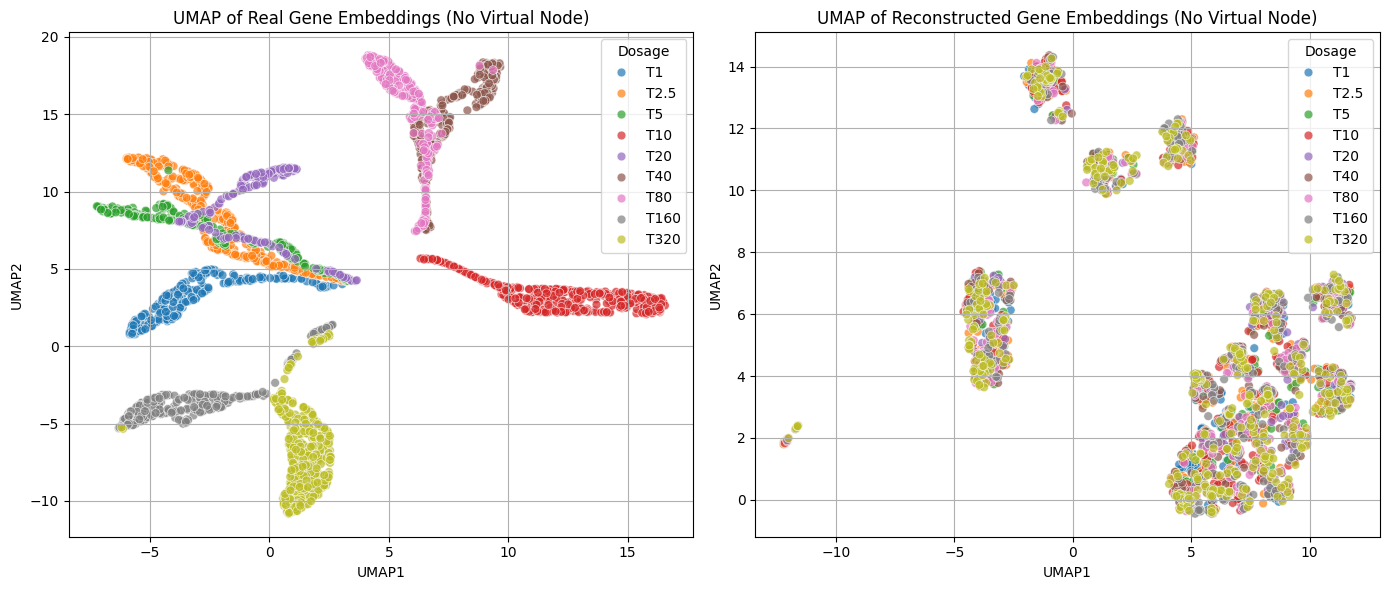

In [92]:
import json
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# === Load saved recon output from No-Virtual-Node model ===
with open("trained_model_no_virtual_recon_outputs.json", "r") as f:
    recon_data = json.load(f)

# === Mapping index to dosage label ===
idx_to_dosage = {
    0: "T1", 1: "T2.5", 2: "T5", 3: "T10", 4: "T20",
    5: "T40", 6: "T80", 7: "T160", 8: "T320"
}

# === Prepare containers
real_feats = []
recon_feats = []
labels = []

for entry in recon_data:
    dosage_name = idx_to_dosage[entry["dosage_idx"]]

    recon_gene = np.array(entry["reconstructed_genes"]).squeeze(0)   # [N_genes, H]
    real_gene = np.array(entry["real_h_gene"]).squeeze(0)           # [N_genes, H]

    recon_feats.append(recon_gene)
    real_feats.append(real_gene)
    labels += [dosage_name] * recon_gene.shape[0]

# === Stack features
recon_all = np.vstack(recon_feats)
real_all = np.vstack(real_feats)

# === Run UMAP
umap_model = umap.UMAP(n_neighbors=30, min_dist=0.3, metric="euclidean", random_state=42)
real_umap = umap_model.fit_transform(real_all)
recon_umap = umap_model.fit_transform(recon_all)

# === Create DataFrames
real_df = pd.DataFrame(real_umap, columns=["UMAP1", "UMAP2"])
real_df["Dosage"] = labels
real_df["Type"] = "Real"

recon_df = pd.DataFrame(recon_umap, columns=["UMAP1", "UMAP2"])
recon_df["Dosage"] = labels
recon_df["Type"] = "Reconstructed"

# === Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(data=real_df, x="UMAP1", y="UMAP2", hue="Dosage", ax=axes[0],
                s=40, alpha=0.7, palette="tab10")
axes[0].set_title("UMAP of Real Gene Embeddings (No Virtual Node)")
axes[0].grid(True)

sns.scatterplot(data=recon_df, x="UMAP1", y="UMAP2", hue="Dosage", ax=axes[1],
                s=40, alpha=0.7, palette="tab10")
axes[1].set_title("UMAP of Reconstructed Gene Embeddings (No Virtual Node)")
axes[1].grid(True)

plt.tight_layout()
plt.savefig("UMAP_GENE_novirtual_attention.png", dpi=600, bbox_inches="tight")
plt.show()


In [94]:
import json
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

# === Load reconstructions ===
with open("trained_model_no_virtual_recon_outputs.json", "r") as f:
    recon_data = json.load(f)

# === Index to dosage mapping ===
idx_to_dosage = {
    0: "T1", 1: "T2.5", 2: "T5", 3: "T10", 4: "T20",
    5: "T40", 6: "T80", 7: "T160", 8: "T320"
}

# === Collect metrics
metrics = []

for entry in recon_data:
    dosage = idx_to_dosage[entry["dosage_idx"]]

    real_gene = np.array(entry["real_h_gene"]).squeeze(0)
    recon_gene = np.array(entry["reconstructed_genes"]).squeeze(0)

    cos_sim = np.mean([
        cosine_similarity(real_gene[i].reshape(1, -1), recon_gene[i].reshape(1, -1))[0, 0]
        for i in range(real_gene.shape[0])
    ])
    mse = mean_squared_error(real_gene, recon_gene)

    metrics.append({
        "Dosage": dosage,
        "CosineSimilarity": cos_sim,
        "MSE": mse
    })

# === Aggregate by dosage
df = pd.DataFrame(metrics)
df_summary = df.groupby("Dosage").mean().reset_index()

# === Optional: sort dosages in order
dosage_order = ["T1", "T2.5", "T5", "T10", "T20", "T40", "T80", "T160", "T320"]
df_summary["Dosage"] = pd.Categorical(df_summary["Dosage"], categories=dosage_order, ordered=True)
df_summary = df_summary.sort_values("Dosage")

# === Print the result
print("===== Per-Dosage Gene Reconstruction Metrics (No Virtual Node) =====")
print(df_summary.to_string(index=False, float_format="%.6f"))

# === Optional: Save to CSV
df_summary.to_csv("metrics_per_dosage_novirtual.csv", index=False)


===== Per-Dosage Gene Reconstruction Metrics (No Virtual Node) =====
Dosage  CosineSimilarity      MSE
    T1          0.899357 0.003145
  T2.5          0.915053 0.002655
    T5          0.914761 0.002664
   T10          0.913497 0.002703
   T20          0.910482 0.002797
   T40          0.914028 0.002687
   T80          0.897814 0.003193
  T160          0.877932 0.003815
  T320          0.878414 0.003800


/home/sachit/.local/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


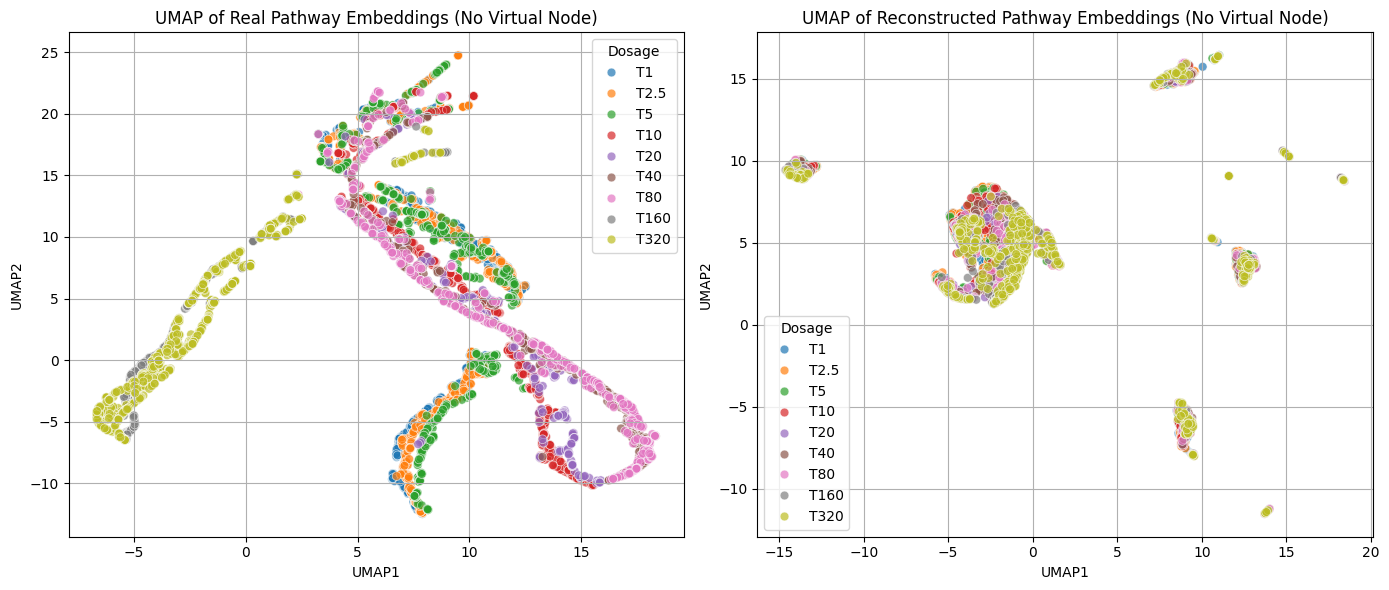

In [95]:
import json
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# === Load JSON outputs from No Virtual Node model ===
with open("trained_model_no_virtual_recon_outputs.json", "r") as f:
    recon_data = json.load(f)

# === Dosage index to label mapping ===
idx_to_dosage = {
    0: "T1", 1: "T2.5", 2: "T5", 3: "T10", 4: "T20",
    5: "T40", 6: "T80", 7: "T160", 8: "T320"
}

# === Containers for pathway embeddings
real_feats = []
recon_feats = []
labels = []

# === Aggregate pathway-level features
for entry in recon_data:
    dosage = idx_to_dosage[entry["dosage_idx"]]

    real_pw = np.array(entry["real_h_pathway"]).squeeze(0)
    recon_pw = np.array(entry["reconstructed_pathways"]).squeeze(0)

    real_feats.append(real_pw)
    recon_feats.append(recon_pw)
    labels += [dosage] * real_pw.shape[0]

# === Stack real and reconstructed pathway embeddings
real_all = np.vstack(real_feats)
recon_all = np.vstack(recon_feats)

# === Apply UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
real_umap = umap_model.fit_transform(real_all)
recon_umap = umap_model.fit_transform(recon_all)

# === Create DataFrames for plotting
real_df = pd.DataFrame(real_umap, columns=["UMAP1", "UMAP2"])
real_df["Dosage"] = labels
real_df["Type"] = "Real"

recon_df = pd.DataFrame(recon_umap, columns=["UMAP1", "UMAP2"])
recon_df["Dosage"] = labels
recon_df["Type"] = "Reconstructed"

# === Plot side-by-side UMAPs
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(data=real_df, x="UMAP1", y="UMAP2", hue="Dosage", ax=axes[0],
                s=40, alpha=0.7, palette="tab10")
axes[0].set_title("UMAP of Real Pathway Embeddings (No Virtual Node)")
axes[0].grid(True)

sns.scatterplot(data=recon_df, x="UMAP1", y="UMAP2", hue="Dosage", ax=axes[1],
                s=40, alpha=0.7, palette="tab10")
axes[1].set_title("UMAP of Reconstructed Pathway Embeddings (No Virtual Node)")
axes[1].grid(True)

plt.tight_layout()
plt.savefig("UMAP_PATHWAY_novirtual_attention.png", dpi=600, bbox_inches="tight")
plt.show()


In [96]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# === Ensure labels are numpy array
labels = np.array(labels)

# === Dosages in correct order
dosages = ["T1", "T2.5", "T5", "T10", "T20", "T40", "T80", "T160", "T320"]

# === Containers
mse_per_dosage = []
cosine_per_dosage = []

# === Per-dosage reconstruction metrics
for d in dosages:
    idxs = labels == d
    real_d = real_all[idxs]
    recon_d = recon_all[idxs]

    mse = mean_squared_error(real_d, recon_d)
    cos_sim = np.mean(np.diag(cosine_similarity(real_d, recon_d)))

    mse_per_dosage.append(mse)
    cosine_per_dosage.append(cos_sim)

# === Overall reconstruction metrics
overall_mse = mean_squared_error(real_all, recon_all)
overall_cosine = np.mean(np.diag(cosine_similarity(real_all, recon_all)))

# === Create final summary table
df_eval = pd.DataFrame({
    "Dosage": dosages + ["Overall"],
    "MSE": mse_per_dosage + [overall_mse],
    "CosineSimilarity": cosine_per_dosage + [overall_cosine]
})

# === Show results
print("\n===== Per-Dosage Pathway Reconstruction Metrics (No Virtual Node) =====")
print(df_eval.round(6))



===== Per-Dosage Pathway Reconstruction Metrics (No Virtual Node) =====
    Dosage       MSE  CosineSimilarity
0       T1  0.245085          0.586839
1     T2.5  0.244758          0.581270
2       T5  0.243938          0.573849
3      T10  0.240217          0.585110
4      T20  0.236062          0.595257
5      T40  0.236533          0.590965
6      T80  0.233593          0.588949
7     T160  0.231456          0.591072
8     T320  0.229626          0.594361
9  Overall  0.238331          0.587165
